## Importing Libraries

In [26]:
import copy
import os
import glob


import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas

from torchvision import transforms,models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision.datasets import ImageFolder


from sklearn.metrics import classification_report, confusion_matrix


## About Dataset

**Dataset Summary:** Rice Leaf Disease Detection

**Location:** Gangavathi village, Karnataka

**Content:** 200 images of diseased rice leaves

**Classes (4 total, 50 images each):**

- Bacterial Leaf Blight – Caused by Xanthomonas oryzae pv. oryzae; symptoms: yellow-brown water-soaked streaks, leaf wilting.

- Blast – Caused by Magnaporthe oryzae; symptoms: diamond-shaped lesions on panicles, nodes, and leaves.

- Brown Spot – Caused by Bipolaris oryzae; symptoms: small circular brown lesions, reduced photosynthesis and yield.

- False Smut – Caused by Ustilaginoidea virens; symptoms: greenish-yellow to black spore balls on grains, affecting quality and yield.

**Disease Management:** Use of resistant varieties, crop rotation, balanced fertilization, and appropriate chemical treatments (fungicides/bactericides).

## Loading Images From Each Class

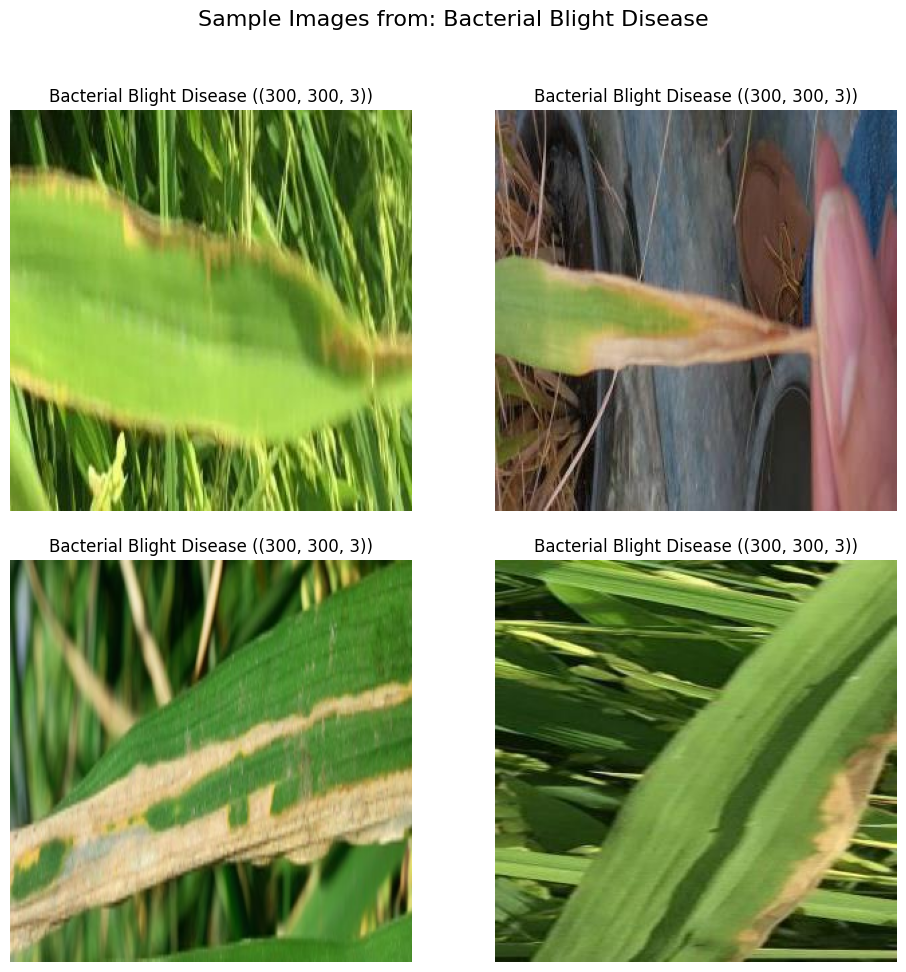


----------------------------------------------------------------------



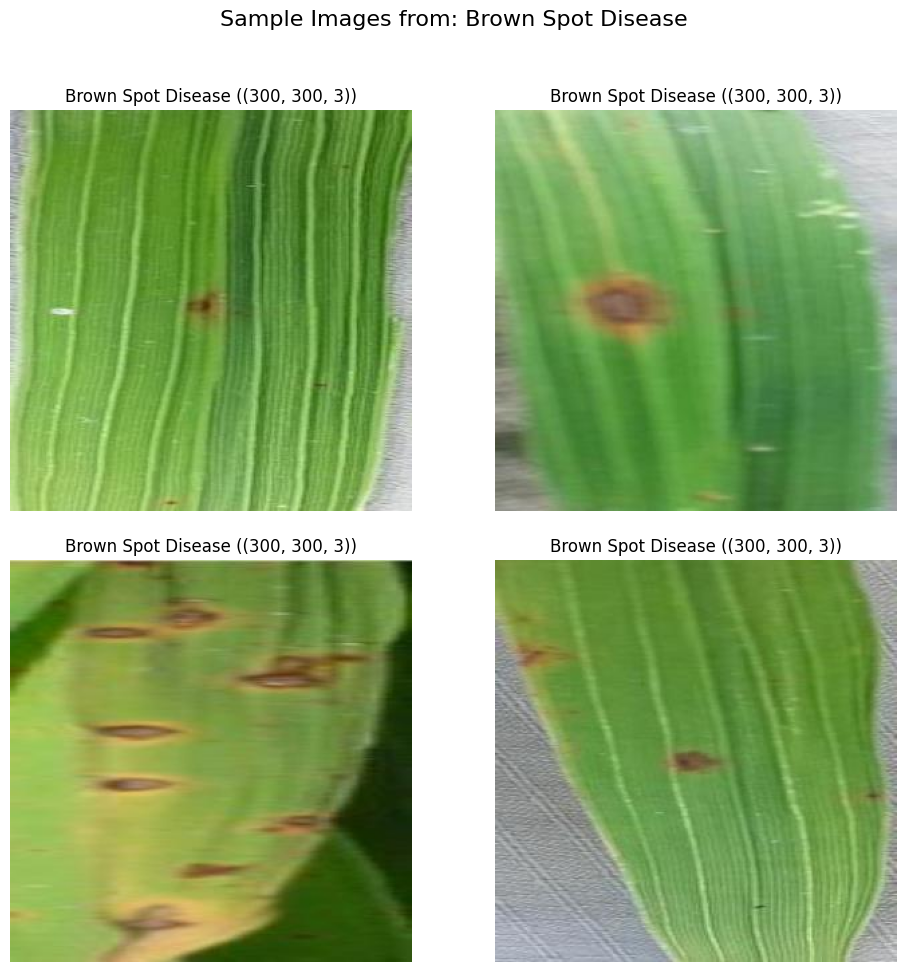


----------------------------------------------------------------------



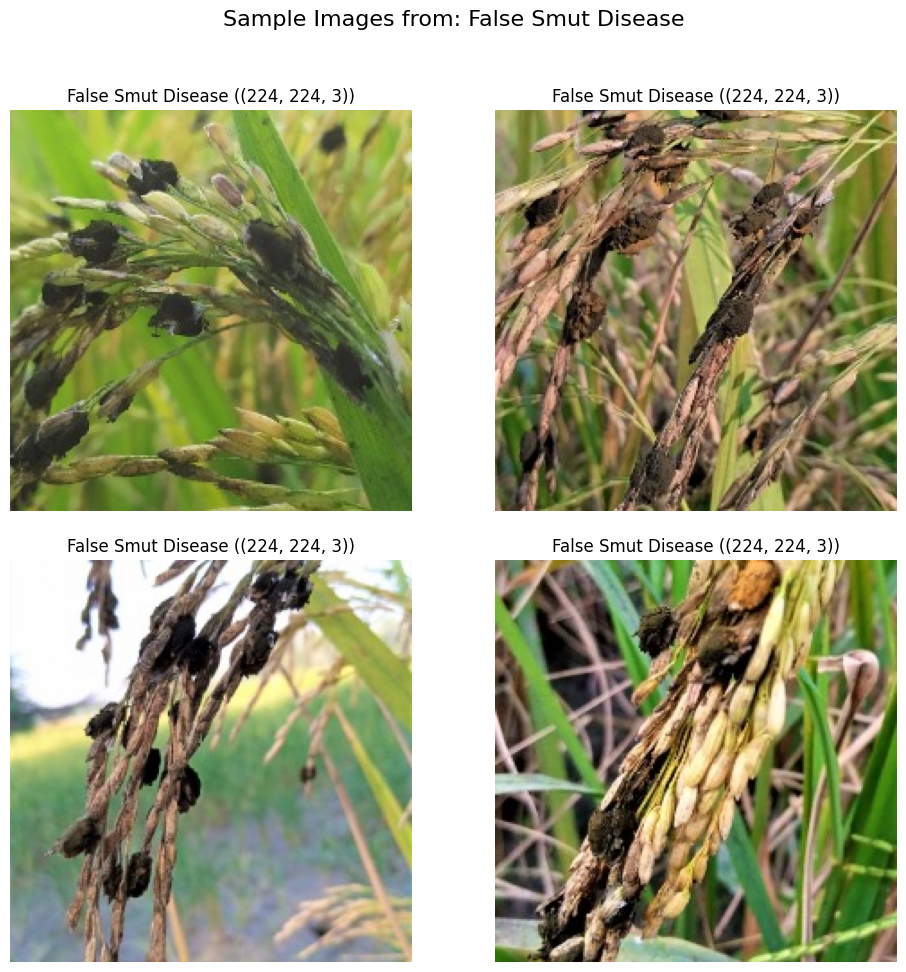


----------------------------------------------------------------------



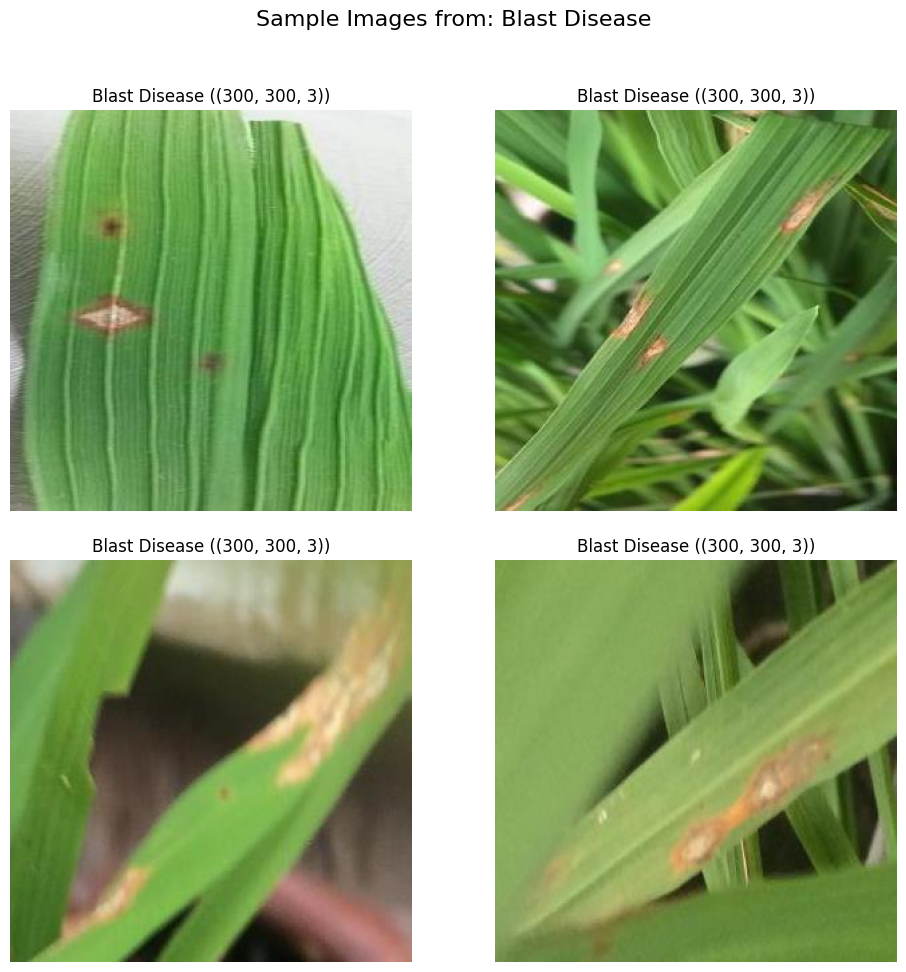


----------------------------------------------------------------------



In [2]:
Base_Dir = '/kaggle/input/rice-crop-diseases/Rice_Diseases'

for folder in os.listdir(Base_Dir):
    image_files = os.listdir(os.path.join(Base_Dir, folder))
    plt.figure(figsize=(10, 10))

    for i in range(4):  # Show 4 images per class
        img_path = os.path.join(Base_Dir, folder, image_files[i])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 2, i + 1)
        plt.imshow(image)
        plt.title(f"{folder} ({image.shape})")
        plt.axis('off')

    plt.suptitle(f"Sample Images from: {folder}", fontsize=16)
    plt.tight_layout(pad=2.0)  # Increased padding between subplots
    plt.subplots_adjust(top=0.88)  # Make space for suptitle
    plt.show()
    
    print("\n" + "-"*70 + "\n")  # Visual separator in notebook output


## Visualizing Image Sizes Before Resizing

The images are of different sizes; some are 300x300x3 while others are 224x224x3. Since ResNet18 expects input images of size 224x224x3, we need to resize all images accordingly.

## Image Preprocessing (PyTorch)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    
])



## Preparing DataLoaders

In [4]:
# Load Entire dataset
dataset = ImageFolder(root = '/kaggle/input/rice-crop-diseases/Rice_Diseases', transform = transform)

total_size = len(dataset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

# Split
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size]
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Size Of Training Data: {len(train_dataset)}")
print(f"Size Of Testing Data: {len(test_dataset)}")
print(f"Size Of Validation Data: {len(val_dataset)}")


# Dictionary For Training
dataloaders = {'train': train_loader,
                'val': val_loader
              }
                        

Size Of Training Data: 160
Size Of Testing Data: 20
Size Of Validation Data: 20


## Model Loading And Customize Final Layer

In [5]:
model = models.resnet18(weights='DEFAULT')

# Get number of input features of the orignal FC layer
in_features = model.fc.in_features

# Replace final layer with your 4-class classifier
model.fc = nn.Linear(in_features, 4)

# Optional: Freeze earlier layers of doing feature extraction only
for param in model.parameters():
    param.requires_grad = True

# Only train final FC layer
for param in model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s] 


## Setting Up Loss Function, Optimizer and Scheduler

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [9]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, save_path='best_model.pth'):
    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, save_path)  # <--- Save the model
        
        scheduler.step()

    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model



## Device Setup

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Starting Training

In [11]:
model = train_model(
    model = model,
    dataloaders = dataloaders,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    num_epochs = 20
             
)

Epoch 1/20
--------------------
Train Loss: 0.8628 Acc: 0.7438
Val Loss: 156.2582 Acc: 0.4000
Epoch 2/20
--------------------
Train Loss: 0.5424 Acc: 0.8500
Val Loss: 11.5374 Acc: 0.6000
Epoch 3/20
--------------------
Train Loss: 0.1936 Acc: 0.9625
Val Loss: 2.3094 Acc: 0.7000
Epoch 4/20
--------------------
Train Loss: 0.1565 Acc: 0.9500
Val Loss: 2.6145 Acc: 0.6000
Epoch 5/20
--------------------
Train Loss: 0.1250 Acc: 0.9625
Val Loss: 0.3618 Acc: 0.9500
Epoch 6/20
--------------------
Train Loss: 0.0748 Acc: 0.9812
Val Loss: 0.4067 Acc: 0.8000
Epoch 7/20
--------------------
Train Loss: 0.2917 Acc: 0.9250
Val Loss: 0.4735 Acc: 0.8000
Epoch 8/20
--------------------
Train Loss: 0.1583 Acc: 0.9437
Val Loss: 0.2200 Acc: 0.9500
Epoch 9/20
--------------------
Train Loss: 0.1070 Acc: 0.9688
Val Loss: 0.1738 Acc: 0.9500
Epoch 10/20
--------------------
Train Loss: 0.0896 Acc: 0.9688
Val Loss: 0.1339 Acc: 0.9500
Epoch 11/20
--------------------
Train Loss: 0.0280 Acc: 1.0000
Val Loss: 0.

## Testing Model & Evaluation

In [12]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [14]:
class_names = dataset.classes  # Automatically gets folder names

print(classification_report(y_true, y_pred, target_names=class_names))

                          precision    recall  f1-score   support

Bacterial Blight Disease       0.86      1.00      0.92         6
           Blast Disease       1.00      0.80      0.89         5
      Brown Spot Disease       0.67      1.00      0.80         2
      False Smut Disease       1.00      0.86      0.92         7

                accuracy                           0.90        20
               macro avg       0.88      0.91      0.88        20
            weighted avg       0.92      0.90      0.90        20



[[6 0 0 0]
 [0 4 1 0]
 [0 0 2 0]
 [1 0 0 6]]


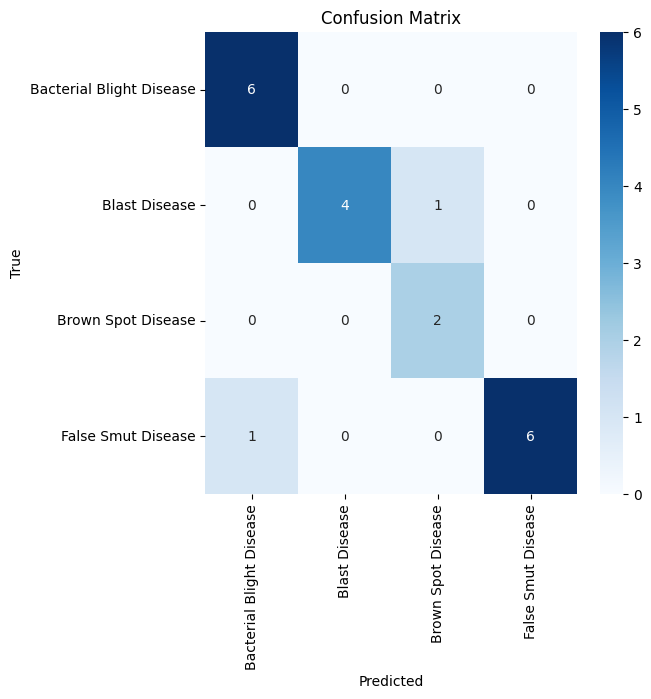

In [27]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Let's Visualize Some Images to get better understanding of the wrong predictions

In [22]:
def imshow(inp):
    """Unnormalize and show image"""
    inp = inp.numpy().transpose((1, 2, 0))  # CHW to HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


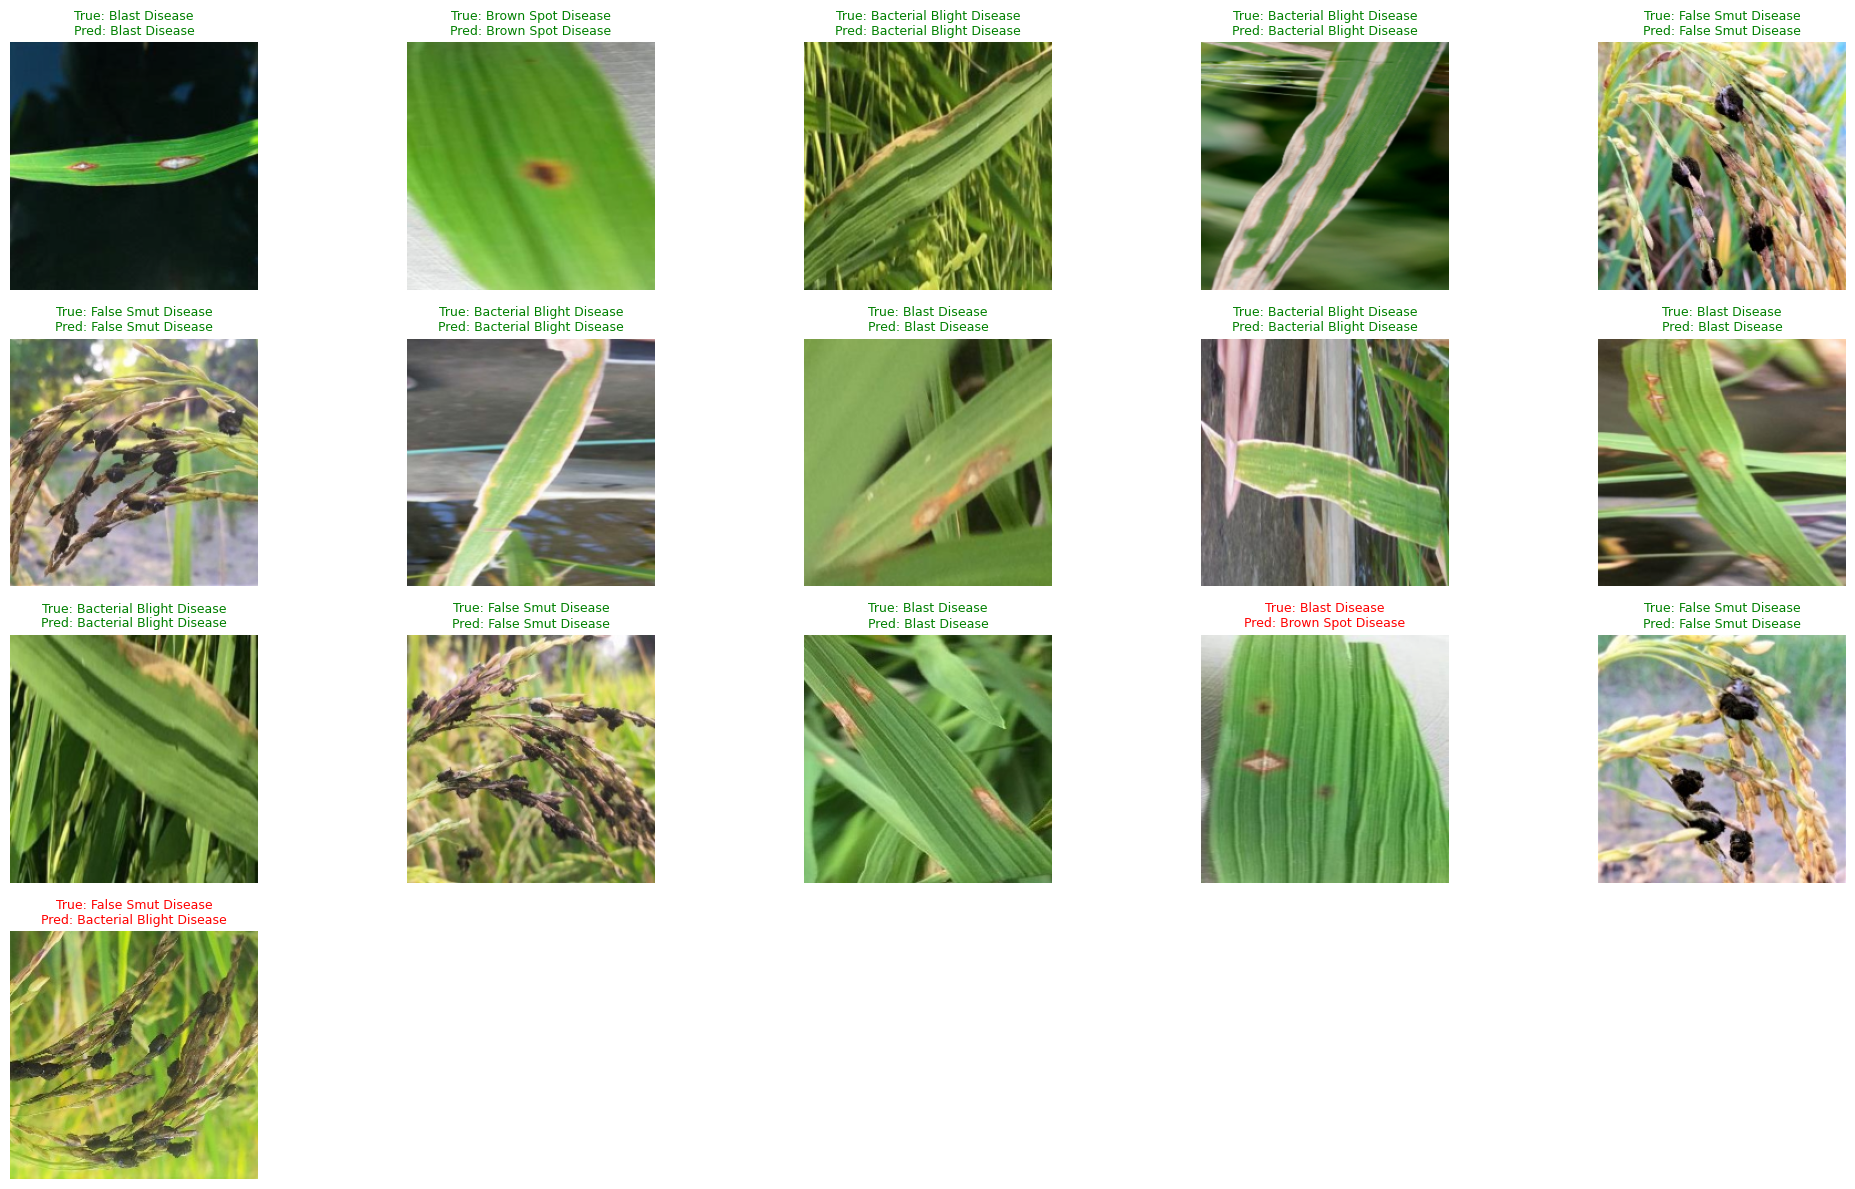

In [25]:
model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

num_images = images.size(0)  # Get actual batch size (e.g., 16)

plt.figure(figsize=(20, 12))

for i in range(num_images):
    ax = plt.subplot(4, 5, i + 1)
    plt.sca(ax)
    imshow(images[i].cpu())

    true_label = dataset.classes[labels[i].item()]
    pred_label = dataset.classes[preds[i].item()]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                 color='green' if true_label == pred_label else 'red',
                 fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Model Performance Summary (Rice Crop Disease)

## Evaluation Metrics (on Test Set of 20 Images): ##


| Metric          | Value |
| --------------- | ----- |
| **Accuracy**    | 90%   |
| **Macro F1**    | 88%   |
| **Weighted F1** | 90%   |


## Class-wise Performance:

| Class Name       | Precision | Recall | F1-Score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| Bacterial Blight | 0.86      | 1.00   | 0.92     | 6       |
| Blast Disease    | 1.00      | 0.80   | 0.89     | 5       |
| Brown Spot       | 0.67      | 1.00   | 0.80     | 2       |
| False Smut       | 1.00      | 0.86   | 0.92     | 7       |


## Conclusions & Insights  

* The model performs very well across all classes despite a small dataset.

* Bacterial Blight and Brown Spot were classified perfectly (Recall = 1.0).

* Blast Disease had one false negative (misclassified as Brown Spot).

* False Smut had one misclassification, likely due to visual similarity with Bacterial Blight.

## Recommendations for Improvement


1. Data Augmentation: Enhance the training set size to make the model more robust.
   
2. Class Balance: Some classes have only 2–5 examples in test — increasing this can stabilize metrics.

   
3. Model Tuning: Explore training for more epochs, adjusting learning rate, or using deeper networks like ResNet34 if performance plateaus.


